## Chebyshev ideas notebook

This notebook will explain the basic ideas behind the Chebyshev method for interpolating multivariate functions based on their evaluation at a limited number of points. To this end, the ideas will be explained using vectors. In the next notebook, they will be applied on Matrix Product States (MPS).


In [2]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt

### 1. Definition

Chebyshev polynomials are orthogonal polynomials defined by the recurrence relation:

$$
T_{d+1}=2 x T_d-T_{d-1}, \quad d \geq 1, \quad T_0 = 1, \quad T_1 = x
$$

where $d$ is the order of the polynomial, which corresponds to the order of the dominant monomial. For example, we have that:

$$
T_0(x)=1, \quad T_1(x)=x, \quad T_2(x)=2 x^2-1, \quad T_3(x)=4 x^3-3 x, \quad T_4(x)=8 x^4-8 x^2+1, \ldots
$$

These polynomials have an explicit form as follows

$$
T_d(x)=\cos (d \arccos x),
$$

this is due to the fact that they are closely related to the Fourier expansions.

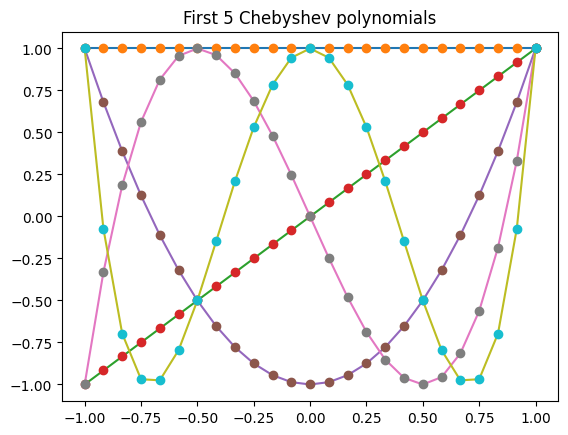

In [6]:
def cheb_trigonometric(x, d):
    return np.cos(d * np.arccos(x))

def cheb_recurrence(x, d):
    if d == 0:
        return np.ones(len(x)) 
    elif d == 1:
        return x
    else:
        return 2*x*cheb_recurrence(x, d-1) - cheb_recurrence(x, d-2)

x = np.linspace(-1, 1, 25)
for d in range(5):
    y_trig = cheb_trigonometric(x,d)
    y_rec = cheb_recurrence(x,d)
    plt.plot(x, y_trig)
    plt.plot(x, y_rec, 'o')
plt.title("First 5 Chebyshev polynomials")
plt.show()

The domain of $x$ for these polynomials must be between -1 and 1. If $x$ falls outside this domain, the polynomials diverge and are no longer orthogonal, and thus are not able to approximate any function:

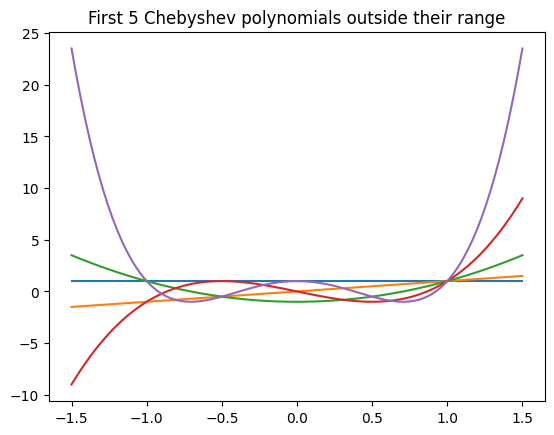

In [12]:
x = np.linspace(-1.5, 1.5, 100)
for d in range(5):
    y_rec = cheb_recurrence(x,d)
    plt.plot(x, y_rec)
plt.title("First 5 Chebyshev polynomials outside their range")
plt.show()

### 2. Expansion of one-dimensional functions

Chebyshev polynomials exhibit both continuous and discrete orthogonality properties:

$$
\text{Continuous:} \qquad \int_{-1}^{+1} \frac{T_i(x) T_j(x)}{\sqrt{1-x^2}} \mathrm{~d} x= \begin{cases}0 & i \neq j \\ \pi / 2 & i=j \neq 0 \\ \pi & i=j=0\end{cases}
$$

$$
\text{Discrete:} \qquad \sum_{k=1}^d T_i\left(\bar{x}_k\right) T_j\left(\bar{x}_k\right)= \begin{cases}0 & i \neq j \\ d / 2 & i=j \neq 0 \\ d & i=j=0\end{cases}
$$

where $\bar{x}_k$ are the Chebyshev zeros. A polynomial of order $d$ has $d$ zeros:

$$
\bar{x}_k=\cos \frac{\pi(2 k-1)}{2 d}, \quad k=1,2,3, \ldots, d
$$

For this reason, Chebyshev polynomials can be used as a basis on which to expand functions. For example, for a one-dimensional function $f(x)$:

$$
f(x) \approx \sum_{i=0}^{D-1} c_i T_i(x)
$$

In this case, $D$ is the order of the expansion, that is, the order of the dominant Chebyshev polynomial (and hence of the dominant monomial of the expansion).

The constants $c_i$ can be calculated from the continuous orthogonality relation by integration. However, it is more useful to use the discrete orthogonality relation to compute them as:

$$
\begin{aligned}
c_0 & =\frac{1}{D} \sum_{k=1}^D f\left(\bar{x}_k\right), \\
c_i & =\frac{2}{D} \sum_{k=1}^D f\left(\bar{x}_k\right) T_i\left(\bar{x}_k\right)
\end{aligned}
$$

In practice, this boils down to a matrix product by vector. For this reason, it is useful to know the evaluation value of the Chebyshev polynomials at their zeros as:

$$
T_i\left(\bar{x}_k\right)=\cos \frac{i(2 k-1) \pi}{2 d}, \quad i<d
$$


In [54]:
def _zeros_evaluated(d, i):
    return np.array([np.cos(np.pi * i * (2 * k - 1) / (2 * d)) for k in range(1, d + 1)])

def _zeros(d):
    return _zeros_evaluated(d, i=1)

def _zeros_matrix(d):
    zeros_matrix = _zeros_evaluated(d, np.arange(d))
    zeros_matrix[:, 0] *= 0.5
    return zeros_matrix

def _coef_vector(d, func):
    zeros = _zeros(d)
    prefactor = 2/d
    func_vector = func(zeros)
    zeros_matrix = _zeros_matrix(d)
    coef_vector = prefactor * func_vector @ zeros_matrix
    return coef_vector

For example, we can try to compute the expansion of an arbitrary smooth function as a Gaussian:

$$ f(x) = e^{-x^2}$$

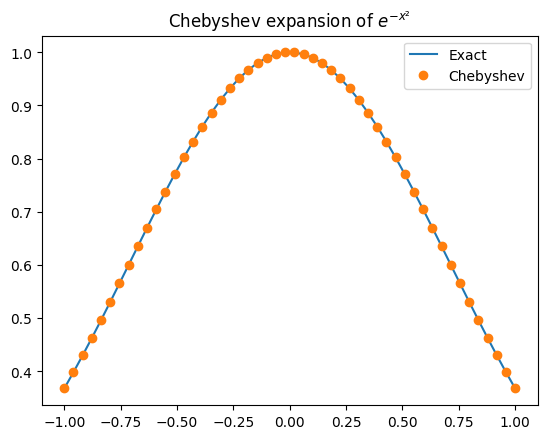

In [55]:
start = -1
stop = 1
x = np.linspace(start, stop, 50)
d = 20
func = lambda x: np.exp(-x**2)
coef_vector = _coef_vector(d, func)
func_cheb = np.zeros(len(x))
for i in range(d):
    func_cheb += coef_vector[i] * cheb_recurrence(x, i)

plt.plot(x, func(x), label='Exact')
plt.plot(x, func_cheb, 'o', label='Chebyshev')
plt.legend()
plt.title(r"Chebyshev expansion of $e^{-x²}$")
plt.show()

### 3. Expansion of multivariate functions

It is possible to perform an expansion of an arbitrary multivariate function $f(x_1, x_2, \ldots, x_m)$ in an analogous way:

$$ f(x_1, x_2, \ldots, x_m)=\sum_{i_1=0}^{D_1-1} \sum_{i_2=0}^{D_2-1} \ldots \sum_{i_m=0}^{D_m-1} c_{i_1 i_2 \ldots i_m} T_{i_1}(x_1) T_{i_2}(x_2)\ldots T_{i_m}(x_m) $$

where in this case the tensor of coefficients $c_{i_1 i_2 i_2 \ldots i_m}$ is of the form:

$$
\begin{aligned}
c_{0\ldots0} & =\frac{1}{V} \sum_{k_1=1}^{d_1} \ldots \sum_{k_m=1}^{d_m} f\left(\bar{x}_{k_1},\ldots, \bar{x}_{k_m} \right), \\
c_{0 \ldots i_\ell \ldots0} & =\frac{2}{V} \sum_{k_1=1}^{d_1} \sum_{k_2=1}^{d_2}\ldots \sum_{k_m=1}^{d_m} f\left(\bar{x}_{k_1}, \bar{x}_{k_2},\ldots, \bar{x}_{k_m} \right) T_{i_\ell}\left(\bar{k}_{\ell}\right), \\
c_{i_1 \ldots i_m} & =\frac{2^m}{V} \sum_{k_1=1}^{d_1}\ldots \sum_{k_m=1}^{d_m} f\left(\bar{x}_{k_1},\ldots, \bar{x}_{k_m} \right) T_{i_1}\left(\bar{x}_{k_1}\right) \ldots T_{i_m}\left(\bar{x}_{k_m}\right) ,
\end{aligned}
$$

where $V = \prod_i^m D_{i=1} = D_1 D_2 \ldots D_m$.

This is just a product of a tensor with a set of matrices:

<img src="images/coef_tensor.png" alt="drawing" width="200"/>

We can generalize the above code as:

In [53]:
def _func_tensor(func, starts, stops, orders):
    pass

def _coef_tensor(func, starts, stops, orders):
    prefactor = (2 ** len(orders)) / (np.prod(orders))
    coef_tensor = prefactor * _func_tensor(func, starts, stops, orders)
    for idx, order in enumerate(orders):
        matrix = _zeros_matrix(order)
        coef_tensor = np.swapaxes(coef_tensor, 0, idx)
        coef_tensor = np.einsum("i..., ik... -> k...", coef_tensor, matrix)
        coef_tensor = np.swapaxes(coef_tensor, idx, 0)
    return coef_tensor

def _chebyshev_partial_sum(func, starts, stops, orders):
    coef_tensor = _coef_tensor(func, starts, stops, orders)
    mps = mps_empty(int(np.log2(np.prod(mesh.shape()[:-1]))))
    for each_order in np.ndindex(coef_tensor.shape):
        each_mps = []
        for idx, order in enumerate(each_order):
            interval = deepcopy(mesh.intervals[idx])
            interval.start = -1.0
            interval.stop = 1.0
            name = f"mps_chebyshev-type_{interval.type}-sites_{int(np.log2(interval.size))}"
            each_mps.append(mps_chebyshev(mps_position(interval), order, name))
        mps += coef_tensor[each_order] * join_list(each_mps)
        mps = mps.join(strategy=strategy)
    return mps

Thus, we can expand an arbitrary multivariate function such as:

$$ f(x, y) = e^{-(x^2 + y^2)} $$

In [1]:
starts = [-1.0, -1.0]
stops = [1.0, 1.0]
func = lambda x, y: np.exp(-(x**2 + y**2))
orders = [10, 10]
y_cheb = _chebyshev_partial_sum(func, starts, stops, orders)

NameError: name '_chebyshev_partial_sum' is not defined

In the analysis submodule we find a development of these methods somewhat more optimized and based on auxiliary structures such as a `Mesh` class applied on Matrix Product States (MPS).

### 4. Mejoras sobre la evaluación de polinomios

Although the procedure shown above is valid for an arbitrary multivariate function, it presents some drawbacks:
- It is unstable, as it needs to keep canceling the dominant monomials with large prefactors for each term in the partial sum.
- It can be inefficient when using Matrix Product States, as it needs to precompute the Chebyshev polynomials from the recurrence relationship, store them and then perform the linear combination.

Therefore, there are alternative procedures to evaluate the partial series:
1. Clenshaw's method (stable)
2. The evaluation of the factorization of the polynomial in monomials (efficient, stable?)

#### 4.1 Clenshaw method

The Clenshaw method leverages the recurrence relation of the polynomials to perform a direct evaluation of the partial series. This evaluation does not require the prior calculation and/or storage of the polynomials, but above all it turns out to be much more stable than the direct evaluation. This is important when performing very precise interpolations in order to arrive at the machine precision. 

In the following we show the method for one-dimensional functions, although it can be generalized to several dimensions in a relatively straightforward way.

The method is based on the collapsing the partial sum using the recurrence relation of the polynomials as:

$$
\begin{aligned}
f(x) & =c_0 T_0+c_1 T_1+\ldots+c_{N-2} T_{N-2}+c_{N-1} T_{N-1}, \\
& =c_0 T_0+c_1 T_1+\ldots+c_{N-2} T_{N-2}+y_{N-1} T_{N-1}, \\
& =c_0 T_0+c_1 T_1+\ldots+\left(c_{N-3}-y_{N-1}\right) T_{N-3}+\left(c_{N-2}+2 x y_{N-1}\right) T_{N-2}, \\
& =c_0 T_0+c_1 T_1+\ldots+\left(c_{N-3}-y_{N-1}\right) T_{N-3}+y_{N-2} T_{N-2}, \\
& =c_0 T_0+c_1 T_1+\ldots+\left(c_{N-4}-y_{N-2}\right) T_{N-4}+\left(c_{N-3}-y_{N-1}+2 x y_{N-2}\right) T_{N-3}, \\
& =c_0 T_0+c_1 T_1+\ldots+\left(c_{N-4}-y_{N-2}\right) T_{N-4}+y_{N-3} T_{N-3}, \\
& =\left(c_0-y_2\right) T_0+y_1 T_1 .
\end{aligned}
$$

so that this evaluation simply becomes:

$$
f(x)=y_0-x y_1
$$

where the following quantities have been defined:

$$
\begin{aligned}
y_{N+1} & =0, \\
y_N & =0, \\
y_{N-1} & =c_{N-1}-y_{N+1}+2 x y_N, \\
& \vdots \\
y_1 & =c_1-y_3+2 x y_2, \\
y_0 & =c_0-y_2+2 x y_1 .
\end{aligned}
$$

We can see how this procedure can be slightly less efficient than the evaluation of the partial sum when the polynomials are precomputed, as each step requires two sums instead of one. However, in this case the polynomials do not need to be precomputed, which allows for a better evaluation of the resources required for the algorithm, and the stability is much improved.

In [ ]:
# Método de Clenshaw

### 4.2 Factorization method

An alternative method that can be more efficient when using MPS consists of calculating symbolically the polynomial corresponding to the Chebyshev expansion, calculating the (complex) roots that this polynomial has, and performing a factorization of the polynomial in terms of monomials which always exists due to the fundamental theorem of algebra.

Thus:

$$
f(x) \approx \sum_{i=0}^{D-1} c_i T_i(x) = \sum_{i=0}^{D-1} a_i x^i
$$

Decomposing this polynomial into a product of monomials:

$$f(x) \approx A \cdot \prod_{i=0}^{D-1} (x-r_i)$$

where $A$ is a given numerical prefactor, and $r_i$ are the complex roots of the whole polynomial. This can be more efficient for MPS because each of the $(x-r_i)$ can be constructed as an MPS exactly by defining the tensors. However, the prefactor $A$ grows very fast with the order of the polynomial, so it is necessary to wonder about the stability of the method. 

It is possible to calculate the roots $r_i$ of a polynomial from its coefficients $a_i$ from the so-called companion matrix. Thus, for example, for a polynomial of order 5 with dominant coefficient $a_5$ ($D=6$), it is possible to construct a matrix of the form

$$
C(a) =
\left(\begin{array}{lllll}
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
-\frac{a_0}{a_5} & - \frac{a_1}{a_5} & - \frac{a_2}{a_5} & - \frac{a_3}{a_5} & - \frac{a_4}{a_5}
\end{array}\right)
$$

so that its roots are simply the eigenvalues of $C$. In turn, it is also possible to compute the roots from the Chebyshev coefficient vector, $c_i$, using the so-called Chebyshev companion matrix (again for $D=6$):
$$
\hat{C}(c) =
\left(\begin{array}{lllll}
0 & 1 & 0 & 0 & 0 \\
\frac{1}{2} & 0 & \frac{1}{2} & 0 & 0 \\
0 & \frac{1}{2} & 0 & \frac{1}{2} & 0 \\
0 & 0 & \frac{1}{2} & 0 & \frac{1}{2} \\
-\frac{c_0}{2 c_5} & -\frac{c_1}{2 c_5} & -\frac{c_2}{2 c_5} & -\frac{c_3}{2 c_5}+\frac{1}{2} & -\frac{c_4}{2 c_5}
\end{array}\right)
$$

so that again the roots of $f(x)$ are the eigenvalues of $\hat{C}(c)$.
We would have to see if it is competitive with Clenshaw's method for MPS in terms of stability and efficiency (To-Do).

In [3]:
# Factor method